In [1]:
from itertools import combinations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data Visualization

In [2]:
df = pd.read_csv("data.txt", 
                 sep = "\t", 
                 names = ["Sample", *(["G"+str(x) for x in range(1, 101)]),"Disease"]).replace({"UP": 1, "Down": 0})
df.head()

,Sample,G1,G2,G3,G4,G5,G6,G7,G8,G9,...,G92,G93,G94,G95,G96,G97,G98,G99,G100,Disease
0,Sample1,1,1,0,1,0,1,1,0,0,...,1,1,0,1,0,0,0,1,0,ALL
1,Sample2,1,0,1,0,1,0,0,0,0,...,1,1,0,0,0,0,0,1,1,ALL
2,Sample3,0,0,1,1,1,1,0,1,1,...,1,1,0,1,0,0,1,1,1,ALL
3,Sample4,0,0,0,0,0,0,0,1,0,...,1,0,1,0,0,1,0,1,0,AML
4,Sample5,1,1,0,0,0,0,1,1,1,...,1,1,0,0,0,0,0,1,1,Breast Cancer


In [3]:
dis_map = {"ALL": "Acute_Lymphoblastic_Leukemia", 
           "AML": "Acute_Myeloid_Leukemia", 
           "Breast Cancer": "Breast_Cancer",
           "Colon Cancer": "Colon_Cancer"}

In [4]:
def barplot(df, disease, ax, plot_id):
    temp = df[df["Disease"] == disease]
    temp = temp[temp.columns[~temp.columns.isin(["Sample", "Disease"])]]

    temp2 = pd.DataFrame(temp.mean())
    temp2 = temp2.rename(columns={0: "Up"})

    temp2.plot(kind="bar", ax=ax[plot_id])

    ax[plot_id].plot([0, 100], [0.45, 0.45], color="black", linestyle="--")
    ax[plot_id].plot([0, 100], [0.50, 0.50], color="black")
    ax[plot_id].plot([0, 100], [0.55, 0.55], color="black", linestyle="--")

    ax[plot_id].set_title("Fraction of Up Gene in {} Disease Sample".format(dis_map[disease]))
    return ax

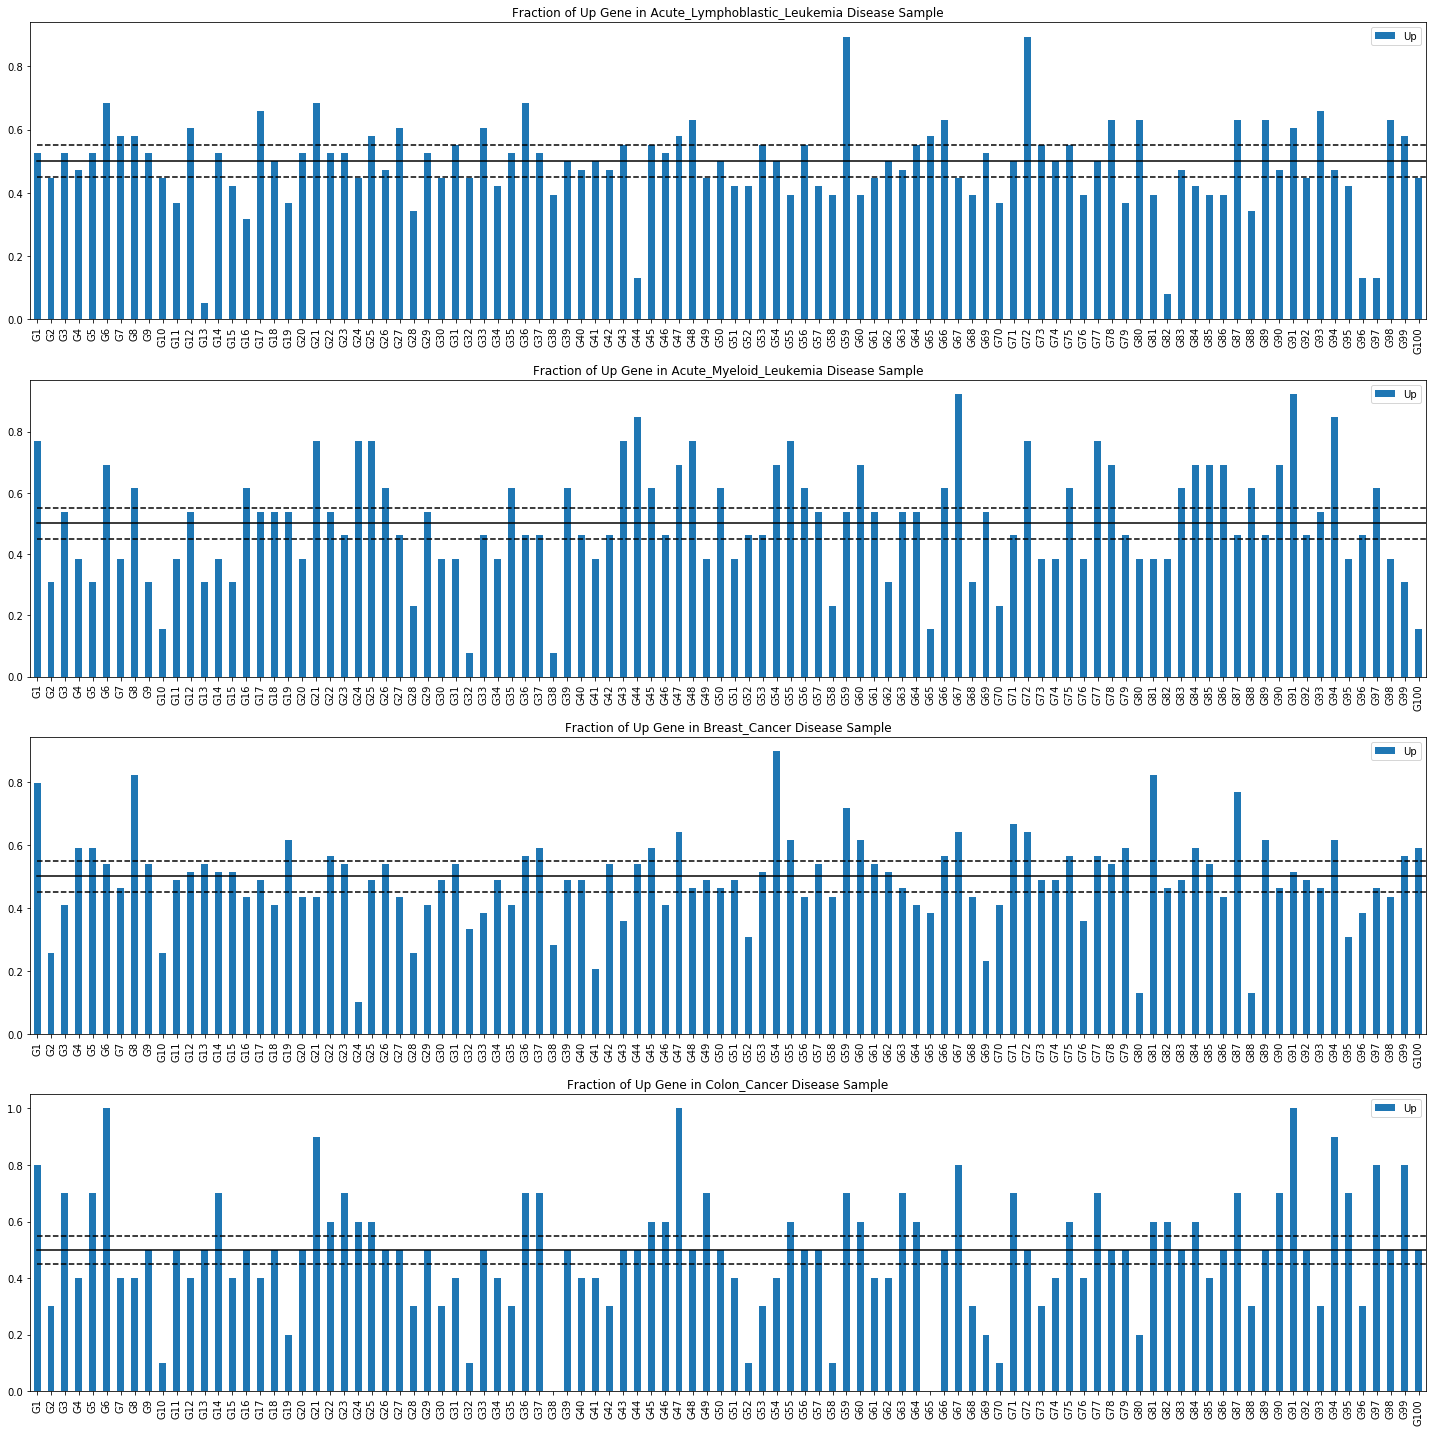

In [5]:
fig, ax = plt.subplots(4, 1, figsize=(20, 20))

for idx, disease in enumerate(dis_map.keys()):
    ax = barplot(df, disease, ax, idx)


fig.tight_layout()

# Data Processing

In [6]:
samples = []
with open("data.txt", "r") as file:
    for x in file.readlines():
        temp = x.split("\t")
        samples.append(set(["{}{}".format(idx+1, status[0]) for idx, status in enumerate(temp[1:-1])]+[dis_map[temp[-1][:-1]]]))

# Naive Apriori Algorithm

In [7]:
class NaiveApriori:
    def __init__(self, data, min_support, min_confidence):
        self.data = data
        self.chars = set.union(*data)
        self.counter = {0: {}}
        self.rules = set()
        
        # Thresholds
        self.min_support = min_support
        self.min_confidence = min_confidence
        
        # Metrics
        self.get_confidence = lambda x, y: self.get_support(set.union(x, y))/self.get_support(x)
        self.get_lift = lambda x, y: self.get_confidence(x, y)/self.get_support(y)
    
        # Utility
        self.__get_key = lambda x: "-".join(sorted(x))
        self.__get_set = lambda x: set(x.split("-"))
        
        
    def __dict_merger(self):
        temp = {}
        for x in self.counter.values():
            temp = {**temp, **x}
        self.counter = temp
        
    def __build_counter(self, ngram):
        # Build counter for item length small than the given item length, if not exist.
        if (ngram-1) not in self.counter.keys():
            self.__build_counter(ngram-1)

        # Prevent creating counter for longer itemlist is support is already exhausted for smaller counter list.
        if (ngram-1) in self.counter:
            if len(self.counter[ngram-1]) > 0 or (ngram-1) == 0:
                itemset = None
                if ngram == 1:
                    # Generate all combinations of items.
                    itemset = list(combinations(self.chars, ngram))
                else:
                    # Apriori property.
                    itemset = list(combinations(set("-".join((self.counter[ngram-1]).keys()).split("-")), ngram))

                # Count for itemlist of length ngram.
                item_count = {self.__get_key(x): 0 for x in itemset}
                for x in itemset:
                    for y in self.data:
                        x = set(x)
                        if len(set.intersection(x, y)) >= ngram :
                            item_count[self.__get_key(x)] += 1
                
                # Drop item combiantion with lower support than threshold.
                keys = list(item_count.keys())
                for key in keys:
                    if item_count[key] < self.min_support:
                        item_count.pop(key)

                self.counter[ngram] = item_count
    
    def get_support(self, key):
        key = self.__get_key(key)
        if key not in self.counter.keys():
            return 0
        return self.counter[key]
    
    def __rule_mining(self):
        keys = list(self.counter.keys())
        for i in range(len(self.counter)-1):
            for j in range(i+1, len(self.counter)):
                a = self.__get_set(keys[i])
                b = set.difference(self.__get_set(keys[j]), self.__get_set(keys[i]))
                con = self.get_confidence(a, b)
                if con >= self.min_confidence:
                    self.rules.add((self.__get_key(a), self.__get_key(b), round(con, 4)))
                con = self.get_confidence(b, a)
                if con >= self.min_confidence:
                    self.rules.add((self.__get_key(b), self.__get_key(a), round(con, 4)))

    def fit(self):
        self.__build_counter(len(self.chars))
        self.__dict_merger()
        self.__rule_mining()

# Implementation

### Toy Dataset

In [8]:
s_sample = [set(list(x)) for x in ["ABE", "BD", "BC", "ABD", "AC", "BC", "AC", "ABCE", "ABC"]]
s_sample

[{'A', 'B', 'E'},
 {'B', 'D'},
 {'B', 'C'},
 {'A', 'B', 'D'},
 {'A', 'C'},
 {'B', 'C'},
 {'A', 'C'},
 {'A', 'B', 'C', 'E'},
 {'A', 'B', 'C'}]

In [9]:
obj = NaiveApriori(s_sample, 2, 0.60)
obj.fit()

In [10]:
obj.counter

{'E': 2,
 'C': 6,
 'D': 2,
 'A': 6,
 'B': 7,
 'A-C': 4,
 'B-C': 4,
 'A-E': 2,
 'B-E': 2,
 'B-D': 2,
 'A-B': 4,
 'A-B-C': 2,
 'A-B-E': 2}

In [11]:
obj.rules

{('A', 'B', 0.6667),
 ('A', 'C', 0.6667),
 ('A-E', 'B', 1.0),
 ('B-E', 'A', 1.0),
 ('C', 'A', 0.6667),
 ('C', 'B', 0.6667),
 ('D', 'B', 1.0),
 ('E', 'A', 1.0),
 ('E', 'A-B', 1.0),
 ('E', 'B', 1.0)}

### Genes Dataset

In [12]:
obj = NaiveApriori(samples, 40, 0.70)
obj.fit()

In [13]:
obj.counter.keys()

dict_keys(['21U', '26D', '35D', '83U', '67U', '66D', '70D', '30U', '23D', '25D', '65D', '88D', '57U', '9D', '45D', '93D', '74U', '7U', '14D', '49U', '99U', '42D', '100U', '5D', '85D', '20D', '11D', '48D', '35U', '2D', '79D', '22U', '77U', '95U', '62U', '12D', '40U', '79U', '3D', '39D', '61U', '98D', '87U', '86U', '24D', '71U', '78U', '97D', '58D', '69D', '50D', '14U', '92U', '84U', '64U', '89U', '37D', '54U', '90U', '73D', '84D', '10D', '86D', '16U', '81D', '91U', '98U', '57D', '1U', '28D', '33D', '17D', '6U', '45U', '64D', '17U', '82D', '49D', '55D', '44D', '32D', '5U', '71D', '80D', '34U', '47U', '31U', '4U', '23U', '60D', '99D', '20U', '42U', '15U', '40D', '51D', '46U', '95D', '7D', '62D', '63U', '26U', '60U', '27D', '55U', '81U', '29D', '77D', '13D', '78D', '30D', '16D', '43D', '61D', '19U', '72U', '100D', '89D', '12U', '75U', '9U', '15D', '39U', '92D', '38D', '93U', '43U', '25U', '56D', '56U', '3U', '37U', '41D', '18U', '66U', '53U', '74D', '19D', '90D', '36U', '27U', '52D', '53D'

In [14]:
obj.rules

{('82D', '97D', 0.75),
 ('29D', '38D', 0.7885),
 ('68D-72U', '59U', 0.9167),
 ('88D', '38D', 0.7042),
 ('72U-96D', '59U-82D', 0.7458),
 ('38D-91U', '70D', 0.7736),
 ('91U', '72U', 0.7385),
 ('1U-67U', '32D', 0.82),
 ('82D-96D', '59U', 0.9231),
 ('28D', '88D', 0.7324),
 ('47U', '2D', 0.7273),
 ('41D', '2D', 0.75),
 ('68D', '6U', 0.7213),
 ('72U-82D-96D', '59U', 0.9167),
 ('33U', '72U', 0.8163),
 ('32D-38D', '91U', 0.7547),
 ('38D-67U', '28D', 0.7843),
 ('52D-65D', '38D', 0.8889),
 ('26U', '10D', 0.7692),
 ('2D', '38D', 0.7576),
 ('32D', '28D', 0.7353),
 ('95D', '28D', 0.7167),
 ('11D', '91U', 0.7193),
 ('38D-69D', '52D', 0.8913),
 ('1U-72U', '38D', 0.7692),
 ('2D', '47U', 0.7273),
 ('70D', '59U', 0.7424),
 ('33D', '88D', 0.7843),
 ('97D', '82D', 0.8361),
 ('38D-41D', '2D', 0.82),
 ('69D', '32D', 0.7419),
 ('69D', '41D', 0.7419),
 ('1U-38D', '32D', 0.7593),
 ('15D', '72U', 0.75),
 ('28D-72U', '59U', 0.8163),
 ('32D-38D', '67U', 0.7925),
 ('41D', '87U', 0.7344),
 ('28D-38D', '87U', 0.7455